## 4.  PYNQ deployment <a id='hw_test'></a>

* [Deployment](#deploy)
* [Validation on PYNQ Board](#validation)
* [Throughput Test on PYNQ Board](#throughput)


The bitfile and generated driver will be copied together with some necessary files for execution into a deployment folder which then can be used to run the network on the PYNQ board.

### Deployment <a id='deploy'></a>

We'll now create a deployment folder with the bitfile and driver file(s), we zip it and afterwards it can be copied to the PYNQ board for execution and validation.

In [3]:
from shutil import copy
from distutils.dir_util import copy_tree
from finn.util.basic import make_build_dir
from qonnx.core.modelwrapper import ModelWrapper

build_dir = "./"
model = ModelWrapper(build_dir + "/tfc_w1_a1_post_synthesis.onnx")

# create directory for deployment files
deployment_dir = make_build_dir(prefix="pynq_deployment_")
model.set_metadata_prop("pynq_deployment_dir", deployment_dir)

# get and copy necessary files
# .bit and .hwh file
bitfile = model.get_metadata_prop("bitfile")
hwh_file = model.get_metadata_prop("hw_handoff")
deploy_files = [bitfile, hwh_file]

for dfile in deploy_files:
    if dfile is not None:
        copy(dfile, deployment_dir)

# driver.py and python libraries
pynq_driver_dir = model.get_metadata_prop("pynq_driver_dir")
copy_tree(pynq_driver_dir, deployment_dir)

['/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/qonnx/core/__init__.py',
 '/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/qonnx/core/datatype.py',
 '/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/qonnx/util/__init__.py',
 '/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/qonnx/util/basic.py',
 '/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/driver.py',
 '/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/experiments/yolov8/finn_build_dir//pynq_deployment_x_4cdmv4/finn/util/__init__.py

Next to these files, we will also need an example numpy array to test the network on the PYNQ board. You may recall that one "reshape" node was left out of the StreamingDataflowPartition. We'll do that manually with a numpy function call when passing in the input, but everything else in the network ended up inside the StreamingDataflowPartition so that's all we need to do. The example numpy array can then be saved as .npy file. 

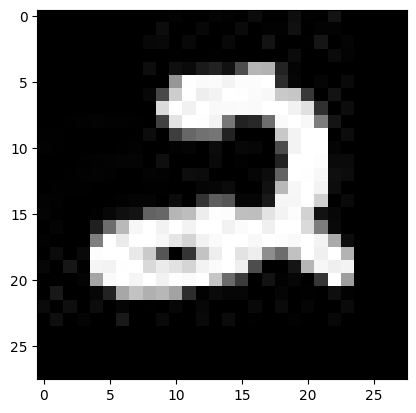

In [5]:
from pkgutil import get_data

import onnx
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt

raw_i = get_data("qonnx.data", "onnx/mnist-conv/test_data_set_0/input_0.pb")
x = nph.to_array(onnx.load_tensor_from_string(raw_i))
plt.imshow(x.reshape(28,28), cmap='gray')

In [7]:
import numpy as np

parent_model = ModelWrapper(build_dir + "/tfc_w1_a1_dataflow_parent.onnx")
model = ModelWrapper(build_dir + "/tfc_w1_a1_post_synthesis.onnx")
iname = model.graph.input[0].name
oname = parent_model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))
np.save(deployment_dir + "/input.npy", x.reshape(ishape))

Expected network input shape is [1, 784]


In [8]:
! ls {deployment_dir}

driver_base.py	finn	   qonnx	resizer.hwh	 validate.py
driver.py	input.npy  resizer.bit	runtime_weights


In [9]:
from shutil import make_archive
make_archive('deploy-on-pynq-tfc', 'zip', deployment_dir)

'/home/surajkarki/Documents/My_Workspace/Coding_Works/Master_Project/finn/notebooks/end2end_example/bnn-pynq/deploy-on-pynq-tfc.zip'

You can now download the created zipfile (**File -> Open**, mark the checkbox next to the `deploy-on-pynq-tfc.zip` and select Download from the toolbar), then copy it to your PYNQ board (for instance via `scp` or `rsync`). Then, run the following commands **on the PYNQ board** to extract the archive and run the execution:

```shell
unzip deploy-on-pynq-tfc.zip -d finn-tfc-demo
cd finn-tfc-demo
sudo python3 -m pip install bitstring
sudo python3 driver.py --exec_mode=execute --batchsize=1 --bitfile=resizer.bit --inputfile=input.npy
```

The output will be saved on the PYNQ board as `output.npy` and can be copied to the host and opened with `np.load()`.

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

**Ensure that your PYNQ board has a working internet connecting for the next steps, since there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ board:

```shell
sudo pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading
```

We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the MNIST dataset.

Command to execute on PYNQ board:

```shell
sudo python3 validate.py --dataset mnist --batchsize 1000
```

We see that the final top-1 accuracy is 92.96%, which is very close to the 93.17% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). 

### Throughput Test on PYNQ Board <a id='throughput'></a>
In addition to the functional verification, FINN also offers the possibility to measure the network performance directly on the PYNQ board. This can be done setting the `exec_mode` to `throughput_test`. 
Command to execute on PYNQ board:

```shell
sudo python3 driver.py --exec_mode=throughput_test --batchsize=1000 --bitfile=resizer.bit
```

The network metrics from the throughput test are saved in a file called `nw_metrics.txt` on the PYNQ board. Which can be investigated after running the command above.